In [1]:
from pydrake.examples.pendulum import PendulumParams, PendulumPlant
from pydrake.all import Linearize, LinearQuadraticRegulator
import numpy as np
import control

import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem
import pydrake.forwarddiff

In [105]:
t = Variable("t")
td = Variable("td")
u = Variable("u")

p = PendulumParams()

x = np.hstack([t, td])

dv_0 = td
dv_1 = (-p.damping()/(p.mass()*p.length()**2))*td - (p.gravity()/p.length())*pydrake.forwarddiff.sin(t) + u

x_dot = np.array([dv_0, dv_1])

continuous_vector_system = SymbolicVectorSystem(state=x, input = [u], dynamics=x_dot, output=x)

In [111]:
plant = PendulumPlant()
context = plant.CreateDefaultContext()
plant.get_input_port().FixValue(context, [0])
context.SetContinuousState([np.pi, 0])

linearized_plant = Linearize(plant, context)

A = linearized_plant.A()
B = linearized_plant.B()
Q = np.diag([10, 1])
R = [1]

X, L, G = control.care(A, B, Q, R)

something = LinearQuadraticRegulator(A, B, Q, R)

In [112]:
something[0]

array([[10.74101105,  2.42596626]])

In [113]:
G

array([[10.74101105,  2.42596626]])

In [114]:
A

array([[ 0.  ,  1.  ],
       [19.62, -0.4 ]])

In [115]:
B

array([[0.],
       [4.]])

In [20]:
np.rad2deg(log.data().view()[0][-1])

32.98667452366236

In [2]:
import math

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import (AddMultibodyPlantSceneGraph, ControllabilityMatrix,
                         DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizerCpp, Parser, Saturation, SceneGraph,
                         Simulator, StartMeshcat, WrapToSystem)
from pydrake.examples.pendulum import (PendulumGeometry, PendulumInput,
                                      PendulumPlant, PendulumState)
from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant,
                                        StabilizingLQRController)
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

from underactuated import FindResource, running_as_notebook
from underactuated.meshcat_cpp_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()


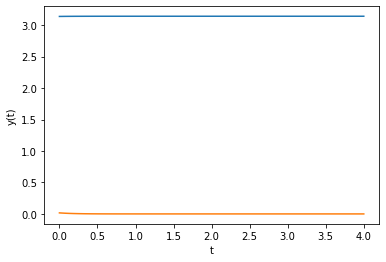

In [62]:
t = Variable("t")
td = Variable("td")
u = Variable("u")

p = PendulumParams()

x = np.hstack([t, td])

dv_0 = td
dv_1 = (-p.damping()/(p.mass()*p.length()**2))*td - (p.gravity()/p.length())*pydrake.forwarddiff.sin(t) + u

x_dot = np.array([dv_0, dv_1])

continuous_vector_system = SymbolicVectorSystem(state=x, input = [u], dynamics=x_dot, output=x)

def UprightState():
#     state = PendulumState()
#     state.set_theta(np.pi)
#     state.set_thetadot(0.)
    return np.array([np.pi, 0])

def acrobot_balancing_example():

    def BalancingLQR():
        global DICK
        # Design an LQR controller for stabilizing the Acrobot around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original AcrobotState coordinates).

        pend = continuous_vector_system
        context = pend.CreateDefaultContext()

        pend.get_input_port(0).FixValue(context, [0])

        context.SetContinuousState(UprightState())

        Q = np.diag((10., 1))
        R = [1]
        
        return LinearQuadraticRegulator(pend, context, Q, R)


    builder = DiagramBuilder()
    pendulum = builder.AddSystem(continuous_vector_system)

    saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
    builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(BalancingLQR())
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 4.0 if running_as_notebook else 0.1
    for i in range(1):
        context.SetTime(0.)
        context.SetContinuousState(UprightState() +
                                0.05 * np.random.randn(2,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');
    

acrobot_balancing_example()

In [68]:
DICK.f0()

array([], dtype=float64)

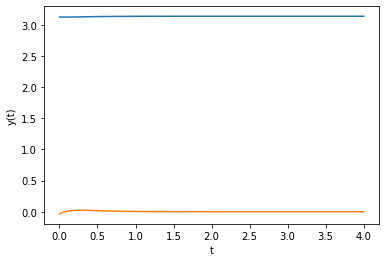

In [138]:
t = Variable("t")
td = Variable("td")

p = PendulumParams()

x = np.hstack([t, td])

u = -G2@(x  - UprightState())
u = u[0]

dv_0 = td
dv_1 = (-p.damping()/(p.mass()*p.length()**2))*td - (p.gravity()/p.length())*pydrake.forwarddiff.sin(t) + u

x_dot = np.array([dv_0, dv_1])

continuous_vector_system = SymbolicVectorSystem(state=x, dynamics=x_dot, output=x)

def UprightState():
#     state = PendulumState()
#     state.set_theta(np.pi)
#     state.set_thetadot(0.)
    return np.array([np.pi, 0])

def acrobot_balancing_example():

    builder = DiagramBuilder()
    pendulum = builder.AddSystem(continuous_vector_system)

    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 4.0 if running_as_notebook else 0.1
    for i in range(1):
        context.SetTime(0.)
        context.SetContinuousState(UprightState() +
                                0.05 * np.random.randn(2,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');
    

acrobot_balancing_example()

In [121]:
A = np.array([[0, 1], [p.gravity()/p.length(), -p.damping()/(p.mass()*p.length()**2)]])
B = np.array([[0], [1]])

Q = np.diag([10, 1])
R = [1]

X, L, G = control.care(A, B, Q, R)

something = LinearQuadraticRegulator(A, B, Q, R)

In [122]:
G

array([[39.4932081 ,  8.55245308]])

In [123]:
something[0]

array([[39.4932081 ,  8.55245308]])

In [124]:
A

array([[ 0.  ,  1.  ],
       [19.62, -0.4 ]])

In [132]:
E = np.array([[1, 0], [0, p.mass()*p.length()**2]])
A = np.array([[0, 1], [p.mass()*p.gravity()*p.length(), -p.damping()]])
B = np.array([[0], [1]])


X, L, G = control.care(A, B, Q, R, E=E)

In [133]:
G

array([[10.74101105,  2.42596626]])

In [135]:
G2 = G/(p.mass()*p.length()**2)